In [14]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from typing import Dict

from saturation.simulation import *
from saturation.distributions import *
from saturation.geometry import *

In [166]:
power_law_distribution = PowerLawProbabilityDistribution(slope=-2.8, min_value=12)

In [176]:
# Alternate implementation
# Scale (x, y) coordinates and cross-join
craters = get_craters(100, power_law_distribution).set_index(['id'])

scale = 1000
craters.x = craters.x * scale
craters.y = craters.y * scale

In [177]:
def get_deletions(craters: pd.DataFrame) -> pd.DataFrame:
    min_id = min(craters.index)
    max_id = max(craters.index)
    
    deletions = []
    for new_id in range(min_id, max_id + 1):
        new_crater = craters.loc[new_id]
        new_x = new_crater.x
        new_y = new_crater.y
        new_radius = new_crater.radius
        
        filtered = craters.loc[range(1, new_id)]
        
        # Filter to only circles that intersect
        distance = np.sqrt((filtered.x - new_x)**2 + (filtered.y - new_y)**2)
        filtered = filtered[(distance < filtered.radius + new_radius) & (distance + new_radius > filtered.radius)]
        
        for row in filtered.itertuples():
            arc = get_intersection_arc((row.x, row.y),
                                       (new_x, new_y),
                                       row.radius,
                                       new_radius)
            
            deletions.append({
                'impacting_id': new_id,
                'impacted_id': row.Index,
                'theta1': arc[0],
                'theta2': arc[1]
            })
            
    return pd.DataFrame(deletions)

In [178]:
deletions = get_deletions(craters)

In [181]:
deletions

,impacting_id,impacted_id,theta1,theta2
0,8,2,0.000000,6.283185
1,11,3,5.248695,0.835495
2,25,19,0.749375,2.119430
3,37,15,4.705401,5.063327
4,43,9,5.250401,0.513849
5,43,16,1.978744,3.319503
6,52,39,2.426624,1.124806
7,55,12,4.212775,6.105614
8,55,18,2.505277,4.051217
9,55,22,0.000000,6.283185


In [186]:
def plot_crater(center: Location, radius: float, arc: Arc, axes_subplot, color: str = 'black', lw: float = 1):
    axes_subplot.add_patch(matplotlib.patches.Arc(center,
                                                  width=radius * 2,
                                                  height=radius * 2,
                                                  theta1=np.rad2deg(arc[0]),
                                                  theta2=np.rad2deg(arc[1]),
                                                  color=color,
                                                  lw=lw))

def plot_intersection(center1: Location, center2: Location, radius1: float, radius2: float, size: float):
    fig, ax = plt.subplots(figsize=(5, 5))

    ax.set_xlim([0, size])
    ax.set_ylim([0, size])

    # Plot craters
    plot_crater(center1, radius1, (0, 2*np.pi), ax, color='green')
    plot_crater(center2, radius2, (0, 2*np.pi), ax)

    # Plot intersection
    arc = get_intersection_arc(center1, center2, radius1, radius2)
    plot_crater(center1, radius1, arc, ax, color='blue', lw=3)

    plt.show()

def plot_up_to_crater(crater_id: int, craters: pd.DataFrame, deletions: pd.DataFrame, scale: float):
    fig, ax = plt.subplots(figsize=(8, 8))

    ax.set_xlim([0, scale])
    ax.set_ylim([0, scale])

    for row in craters.loc[range(1, crater_id + 1)].itertuples():
        plot_crater((row.x, row.y), row.radius, (0, 2*np.pi), ax)

    filtered_deletions = deletions[deletions.impacting_id <= crater_id]
    for row in filtered_deletions.itertuples():
        old_crater = craters.loc[row.impacted_id]
        new_crater = craters.loc[row.impacting_id]

        plot_crater((old_crater.x, old_crater.y),
                    old_crater.radius,
                    (row.theta1, row.theta2),
                    ax,
                    color='blue',
                    lw=3)

    plt.show()

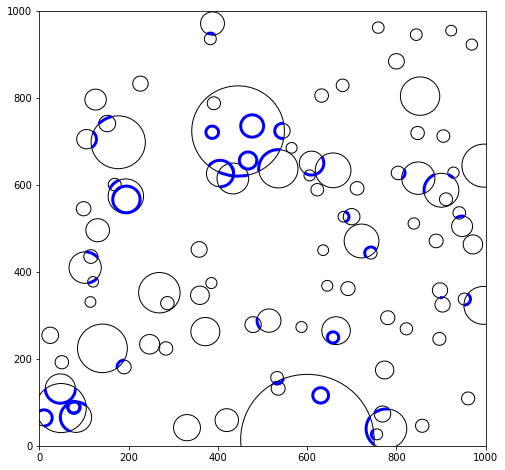

In [187]:
plot_up_to_crater(100, craters, deletions, scale)